# 1 . importing libraries


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding,GRU,LSTM,Bidirectional,SimpleRNN
from tensorflow.keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense,Dropout
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')

# 2 . Get any dependancies

In [2]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# 3| Loading our data

In [77]:
df = pd.read_csv("/kaggle/input/phishingemails/Phishing_Email.csv")

df.head()

Unnamed: 0                                         Email Text  \
0           0  re : 6 . 1100 , disc : uniformitarianism , re ...   
1           1  the other side of * galicismos * * galicismo *...   
2           2  re : equistar deal tickets are you still avail...   
3           3  \nHello I am your hot lil horny toy.\n    I am...   
4           4  software at incredibly low prices ( 86 % lower...   

       Email Type  
0      Safe Email  
1      Safe Email  
2      Safe Email  
3  Phishing Email  
4  Phishing Email

In [78]:
df.size

55950

# 4| Text Preprocessing

In [4]:
df.isnull().sum()

Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

** There are 16 rows available that have null values .Let's remove these rows



## 4.1| Drop duplicates and null values

In [5]:
df.drop(["Unnamed: 0"],axis=1,inplace=True)
df.dropna(inplace=True,axis=0)
df.drop_duplicates(inplace=True)

In [6]:
print("Dimension of the row data:",df.shape)

Dimension of the row data: (17538, 2)


In [7]:
df.head()

Email Text      Email Type
0  re : 6 . 1100 , disc : uniformitarianism , re ...      Safe Email
1  the other side of * galicismos * * galicismo *...      Safe Email
2  re : equistar deal tickets are you still avail...      Safe Email
3  \nHello I am your hot lil horny toy.\n    I am...  Phishing Email
4  software at incredibly low prices ( 86 % lower...  Phishing Email

In [9]:
# Create the bar chart
fig = px.bar(df['Email Type'].value_counts(), x=df['Email Type'].value_counts().index, y=df['Email Type'].value_counts().values,
             color=['blue', 'red'], labels={'x': 'Category', 'y': 'Count'},
             title="Categorical Distribution")

# Show the plot
fig.show(renderer='iframe')

Insigths :

The count of the safe emails is more than that of phishing email so if we see any emails that look like phishing delete

In [10]:
# Create the pie chart
fig_pie = px.pie(df['Email Type'].value_counts(), names=df['Email Type'].value_counts().index,
                 values=df['Email Type'].value_counts().values, title="Categorical Distribution")

# Show the pie chart
fig_pie.show(renderer='iframe')

## 4.3| Integer Encoding

In [11]:
le = LabelEncoder()

df["Email Type"] = le.fit_transform(df["Email Type"])

In [12]:
df

Email Text  Email Type
0      re : 6 . 1100 , disc : uniformitarianism , re ...           1
1      the other side of * galicismos * * galicismo *...           1
2      re : equistar deal tickets are you still avail...           1
3      \nHello I am your hot lil horny toy.\n    I am...           0
4      software at incredibly low prices ( 86 % lower...           0
...                                                  ...         ...
18644  \nRick Moen  a √É¬©crit:> > I'm confused. I thou...           1
18645  date a lonely housewife always wanted to date ...           0
18646  request submitted : access request for anita ....           1
18647  re : important - prc mtg hi dorn & john , as y...           1
18648  press clippings - letter on californian utilit...           1

[17538 rows x 2 columns]

## 4.4 Remove hyperlinks, punctuations, extra space

In [13]:
import re

def preprocess_text(text):
    # Remove hyperlinks
    text = re.sub(r'http\S+', '', text)

    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text


# Apply the preprocess_text function to the specified column in the DataFrame
df["Email Text"] =df["Email Text"].apply(preprocess_text)

In [14]:
df.head()

Email Text  Email Type
0  re 6 1100 disc uniformitarianism re 1086 sex l...           1
1  the other side of galicismos galicismo is a sp...           1
2  re equistar deal tickets are you still availab...           1
3  hello i am your hot lil horny toy i am the one...           0
4  software at incredibly low prices 86 lower dra...           0

# WordCloud

## wordcloud of avaiable stopwords

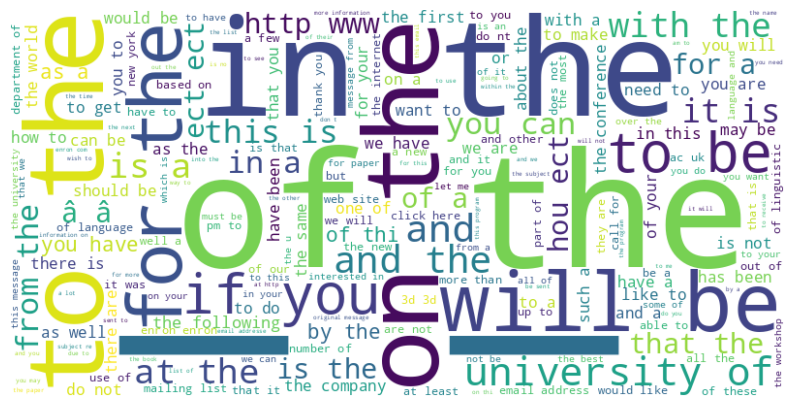

In [15]:
from wordcloud import WordCloud

#combine all rows into a single string
all_mails = " ".join(df['Email Text'])

#create a wordcloud object
word_cloud = WordCloud(stopwords="english",width=800,height=400,background_color='white').generate(all_mails)

plt.figure(figsize=(10,6))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

## wordcloude of unique words

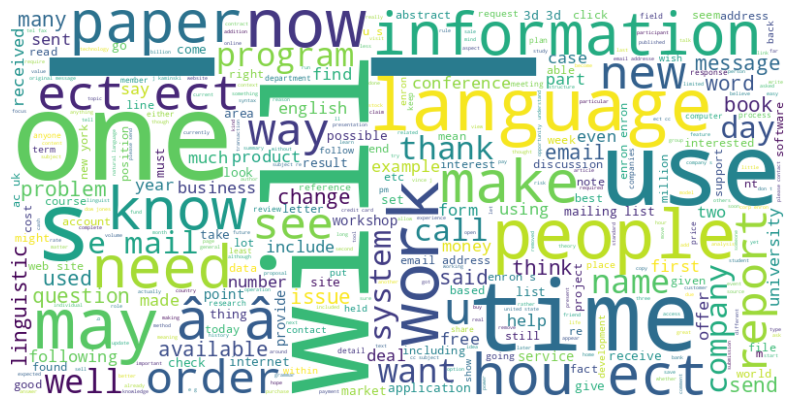

In [16]:
#combine all rows into a single string
all_mails = " ".join(df['Email Text'])

#create a wordcloud object
word_cloud = WordCloud(width=800,height=400,background_color='white',max_words=10000).generate(all_mails)
plt.figure(figsize=(10,6))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

## 4.5 Converting text into vector

### 4.5.1 Tfidf vectorizer

In [17]:
tf = TfidfVectorizer(stop_words="english",max_features=10000) #dimension reduction

feature_x = tf.fit_transform(df["Email Text"]).toarray()

In [18]:
y_tf = np.array(df['Email Type']) # convert the label into numpy array

### 4.5.2 Splitting into train and test

In [19]:
x_train,x_test,y_train,y_test = train_test_split(feature_x,y_tf,train_size=0.8,random_state=0)

# 5| Applying different algorithm

## 5.1| Naive Bayes

In [20]:
#naive bayes works with condtional probability
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(x_train,y_train)

MultinomialNB()

accuracy from native bayes: 97.52 %
f1 score from naive bayes: 97.99 %
classification report :

               precision    recall  f1-score   support

           0       0.97      0.96      0.97      1351
           1       0.98      0.98      0.98      2157

    accuracy                           0.98      3508
   macro avg       0.97      0.97      0.97      3508
weighted avg       0.98      0.98      0.98      3508



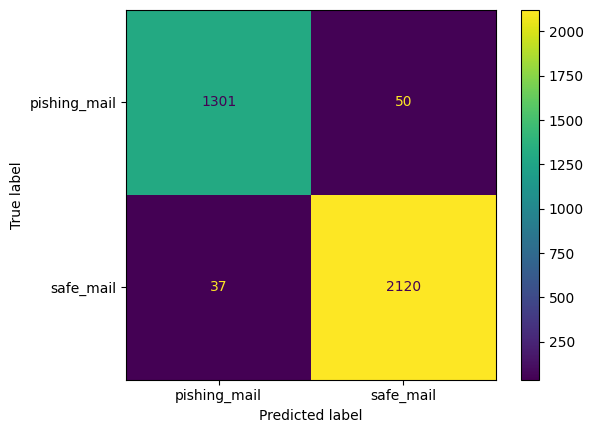

In [21]:
from sklearn.metrics import accuracy_score,f1_score,classification_report,ConfusionMatrixDisplay,confusion_matrix
pred_nav = nb.predict(x_test)

# Checking the performance

print(f"accuracy from native bayes: {accuracy_score(y_test,pred_nav)*100:.2f} %")
print(f"f1 score from naive bayes: {f1_score(y_test,pred_nav)*100:.2f} %")
print("classification report :\n\n",classification_report(y_test,pred_nav))

#confusion matrix
clf_nav = confusion_matrix(y_test,pred_nav)
cx_ = ConfusionMatrixDisplay(clf_nav,display_labels=['pishing_mail','safe_mail']).plot()
plt.show()

## 5.2| Logistic Regression


accuracy from logistic regression:97.98 %
f1 score from logistic regression: 98.36 %
classification report : 
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      1351
           1       0.98      0.99      0.98      2157

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508



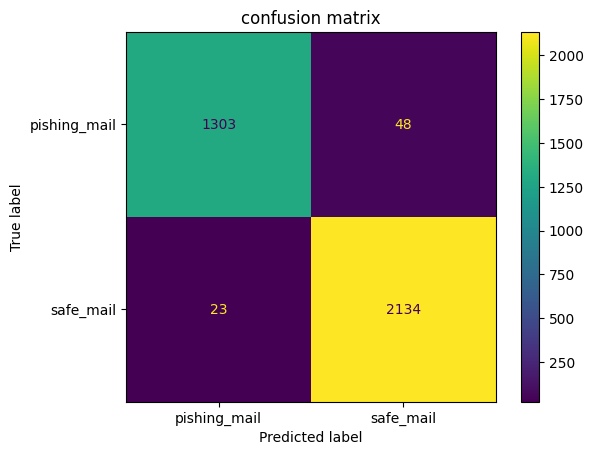

In [22]:
lg = LogisticRegression()
lg.fit(x_train,y_train)

# prediction
pred_lg = lg.predict(x_test)
# performance
print("")
print(f"accuracy from logistic regression:{accuracy_score(y_test,pred_lg)*100:.2f} %")
print(f"f1 score from logistic regression: {f1_score(y_test,pred_lg)*100:.2f} %")
print("classification report : \n",classification_report(y_test,pred_lg))

clf_lg = confusion_matrix(y_test,pred_lg)
cx_ = ConfusionMatrixDisplay(clf_lg,display_labels=['pishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

In [23]:
# save the model for future use

import joblib

# Save the trained model to a file
joblib.dump(nb, 'email_spam_nb.pkl')

['email_spam_nb.pkl']

## 5.3| SGD Classifier

accuracy from logistic regression:98.18 %
f1 score from logistic regression: 98.52 %
classification report : 
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      1351
           1       0.98      0.99      0.99      2157

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508



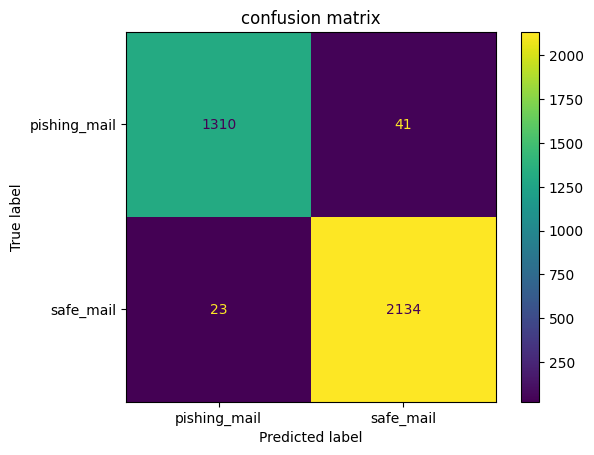

In [24]:
from sklearn.linear_model import SGDClassifier

# passing object
sgd = SGDClassifier()
sgd.fit(x_train,y_train)

# prediction
pred_sgd = sgd.predict(x_test)
# performance
print(f"accuracy from logistic regression:{accuracy_score(y_test,pred_sgd)*100:.2f} %")
print(f"f1 score from logistic regression: {f1_score(y_test,pred_sgd)*100:.2f} %")
print("classification report : \n",classification_report(y_test,pred_sgd))

clf_sgd = confusion_matrix(y_test,pred_sgd)
cx_ = ConfusionMatrixDisplay(clf_sgd,display_labels=['pishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

## 5.4| XGBoost

accuracy from XGB:97.04 %
f1 score from XGB: 97.58 %
classification report : 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      1351
           1       0.98      0.97      0.98      2157

    accuracy                           0.97      3508
   macro avg       0.97      0.97      0.97      3508
weighted avg       0.97      0.97      0.97      3508



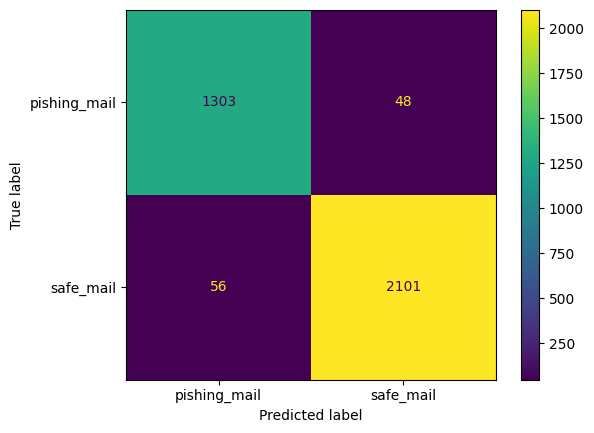

In [25]:
# applying boosting algorithm
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(x_train,y_train)

#prediction
pred_xgb = xgb.predict(x_test)

#performance
print(f"accuracy from XGB:{accuracy_score(y_test,pred_xgb)*100:.2f} %")
print(f"f1 score from XGB: {f1_score(y_test,pred_xgb)*100:.2f} %")
print("classification report : \n",classification_report(y_test,pred_xgb))

#confusion matrix
clf_xgb = confusion_matrix(y_test,pred_xgb)
cx_ = ConfusionMatrixDisplay(clf_xgb,display_labels=['pishing_mail','safe_mail']).plot()
plt.show()

## 5.5| Decision Tree

accuracy from Decision Tree:93.10 %
f1 score from Decision Tree: 94.36 %
classification report : 
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      1351
           1       0.95      0.94      0.94      2157

    accuracy                           0.93      3508
   macro avg       0.93      0.93      0.93      3508
weighted avg       0.93      0.93      0.93      3508



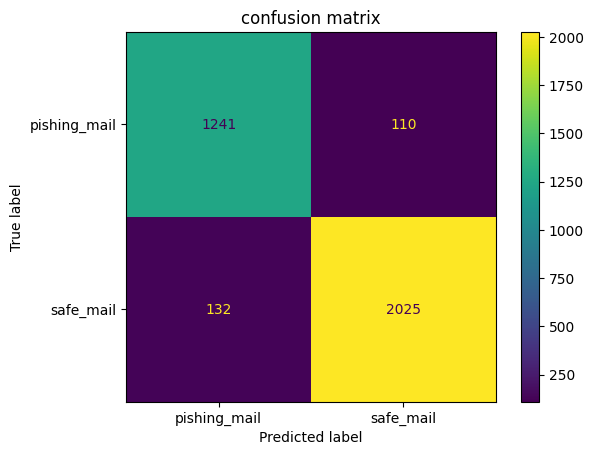

In [26]:
dtr = DecisionTreeClassifier() #passing object
dtr.fit(x_train,y_train)

#prediction
pred_dtr = dtr.predict(x_test)

#performance
print(f"accuracy from Decision Tree:{accuracy_score(y_test,pred_dtr)*100:.2f} %")
print(f"f1 score from Decision Tree: {f1_score(y_test,pred_dtr)*100:.2f} %")
print("classification report : \n",classification_report(y_test,pred_dtr))

#confusion matrix
clf_dtr = confusion_matrix(y_test,pred_dtr)
cx_ = ConfusionMatrixDisplay(clf_dtr,display_labels=['pishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

## 5.6| Random Forest 

accuracy from rnadom forest:97.78 %
f1 score from random forest: 98.18 %
classification report : 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      1351
           1       0.99      0.98      0.98      2157

    accuracy                           0.98      3508
   macro avg       0.97      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508



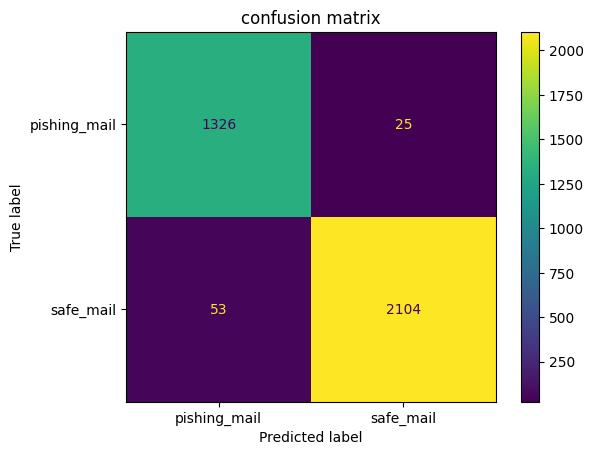

In [27]:
rnf = RandomForestClassifier() #passing object
rnf.fit(x_train,y_train)

#prediction
pred_rnf = rnf.predict(x_test)

#performance
print(f"accuracy from rnadom forest:{accuracy_score(y_test,pred_rnf)*100:.2f} %")
print(f"f1 score from random forest: {f1_score(y_test,pred_rnf)*100:.2f} %")
print("classification report : \n",classification_report(y_test,pred_rnf))

#confusion matrix
clf_rnf = confusion_matrix(y_test,pred_rnf)
cx_ = ConfusionMatrixDisplay(clf_rnf,display_labels=['pishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

## 5.7| MLP Classifier (Multi-Layer perceptrons)

accuracy from MLP:98.49 %
f1 score from MLP: 98.77 %
classification report : 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1351
           1       0.99      0.99      0.99      2157

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508



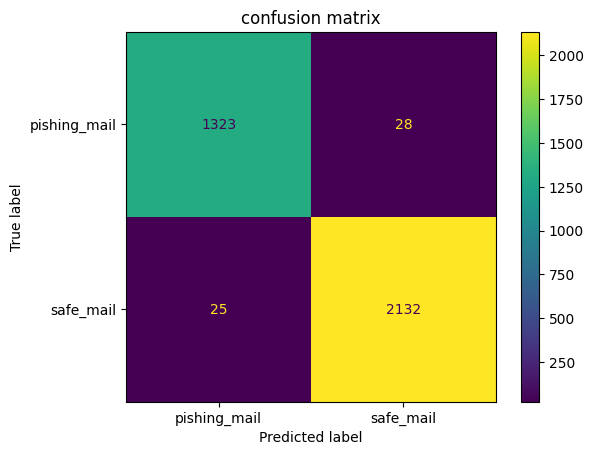

In [28]:
mlp = MLPClassifier()  # passing object
mlp.fit(x_train,y_train)

#prediction
pred_mlp = mlp.predict(x_test)

#performance
print(f"accuracy from MLP:{accuracy_score(y_test,pred_mlp)*100:.2f} %")
print(f"f1 score from MLP: {f1_score(y_test,pred_mlp)*100:.2f} %")
print("classification report : \n",classification_report(y_test,pred_mlp))

#confusion matrix
clf_mlp = confusion_matrix(y_test,pred_mlp)
cx_ = ConfusionMatrixDisplay(clf_mlp,display_labels=['pishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

## 5.8| EDA comparison of the models performances

In [29]:
models = ['Naive bayes', 'Logistic Regression', 'SGD Classifier', 'XGBoost', 'Decision Tree', 'Random Forest', 'MLPClassifier']
accuracies = [97.52, 97.95, 98.57, 97.21, 93.67, 97.72, 98.29]

# Create the bar chart
fig = px.bar(x=models, y=accuracies, labels={'x': 'Models', 'y': 'Accuracy'},
             title="Performance of the models", text=accuracies)

# Customize the layout (optional)
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside', marker_color='magenta')

# Show the plot
fig.show(renderer='iframe')

# 6| NN (Neural Network)

In [30]:
max_len = 150

tk = Tokenizer()

# Process the text

tk.fit_on_texts(df['Email Text'])
sequences = tk.texts_to_sequences(df['Email Text'])
vector = pad_sequences(sequences,padding='post', maxlen=max_len)

In [31]:
len(vector)

17538

In [32]:
x = np.array(vector)
y = np.array(df["Email Type"])

In [33]:
#Split the dataset into train and test set

x_train, x_test, y_train, y_test = train_test_split(vector,df['Email Type'], test_size=0.2, random_state =0)

## 6.1| Simple RNN

In [34]:
model_smp = Sequential() # Sequential() API
model_smp.add(Embedding(input_dim=len(tk.word_index)+1,output_dim=50,input_length=150))
model_smp.add(SimpleRNN(units=100))
model_smp.add(Dropout(0.45))
model_smp .add(Dense(1, activation='sigmoid'))

In [35]:
model_smp.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [36]:
historical_smp  = model_smp.fit(x_train,y_train, epochs=7, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/7
  8/877 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14s 17ms/step - accuracy: 0.5222 - loss: 0.6999

I0000 00:00:1761888480.040791      78 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1761888480.057485      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


877/877 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step - accuracy: 0.5388 - loss: 0.7258

W0000 00:00:1761888496.552030      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


877/877 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 23s 21ms/step - accuracy: 0.5388 - loss: 0.7258 - val_accuracy: 0.6163 - val_loss: 0.6556
Epoch 2/7
877/877 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 15s 17ms/step - accuracy: 0.5893 - loss: 0.6802 - val_accuracy: 0.6408 - val_loss: 0.6284
Epoch 3/7
877/877 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 15s 17ms/step - accuracy: 0.6461 - loss: 0.6092 - val_accuracy: 0.6719 - val_loss: 0.5901
Epoch 4/7
877/877 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 16s 18ms/step - accuracy: 0.7276 - loss: 0.5124 - val_accuracy: 0.7030 - val_loss: 0.5392
Epoch 5/7
877/877 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 16s 18ms/step - accuracy: 0.7614 - loss: 0.4468 - val_accuracy: 0.6759 - val_loss: 0.5619
Epoch 6/7
877/877 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 15s 17ms/step - accuracy: 0.7623 - loss: 0.4377 - val_accuracy: 0.6958 - val_loss: 0.5

Text(0, 0.5, 'Loss')

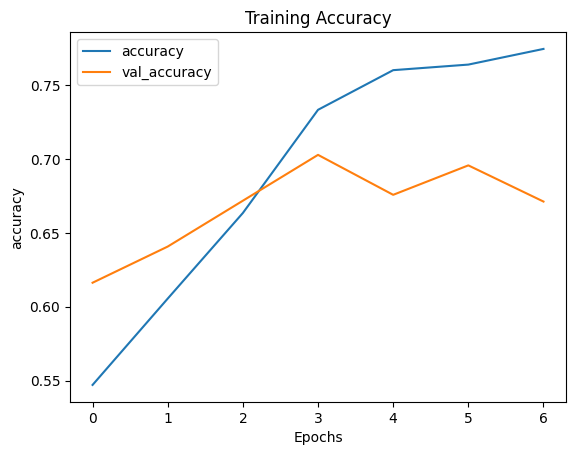

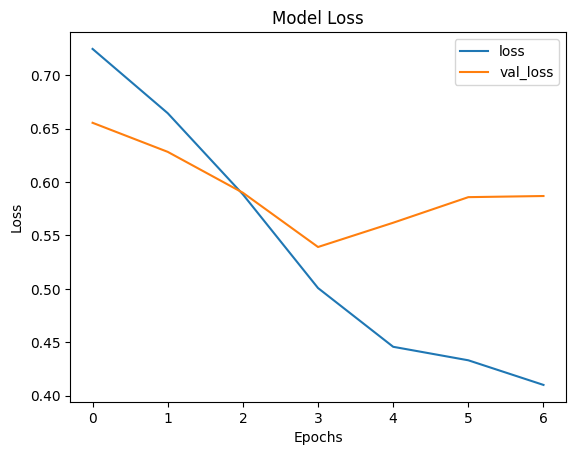

In [37]:
import matplotlib.pyplot as plt
pd.DataFrame(historical_smp.history)

pd.DataFrame(historical_smp.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(historical_smp.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

110/110 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 6ms/step


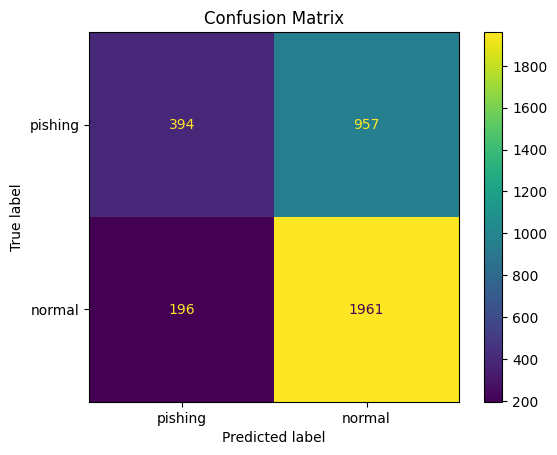

In [38]:
y_pred_prob_smp = model_smp.predict(x_test)
y_pred_smp = (y_pred_prob_smp > 0.5).astype(int)

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cnf_smp = confusion_matrix(y_test,y_pred_smp)
ax_smp = ConfusionMatrixDisplay(confusion_matrix=cnf_smp,display_labels=['pishing','normal']).plot()
plt.title("Confusion Matrix")
plt.show()

## 6.2| LSTM Architecture

In [39]:
model = Sequential() # Sequential() API
model.add(Embedding(input_dim=len(tk.word_index)+1,output_dim=50,input_length=150))
model.add(LSTM(units=100))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [40]:
model.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [41]:
historical  = model.fit(x_train,y_train, epochs=5, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/5
877/877 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14s 11ms/step - accuracy: 0.6888 - loss: 0.5486 - val_accuracy: 0.9504 - val_loss: 0.1821
Epoch 2/5
877/877 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 10ms/step - accuracy: 0.9490 - loss: 0.1850 - val_accuracy: 0.9350 - val_loss: 0.2221
Epoch 3/5
877/877 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 10ms/step - accuracy: 0.9605 - loss: 0.1552 - val_accuracy: 0.9464 - val_loss: 0.2250
Epoch 4/5
877/877 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 11ms/step - accuracy: 0.9510 - loss: 0.1523 - val_accuracy: 0.9407 - val_loss: 0.1827
Epoch 5/5
877/877 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 11ms/step - accuracy: 0.9765 - loss: 0.0912 - val_accuracy: 0.9655 - val_loss: 0.1280


# 7| Performance

In [42]:
results = model.evaluate(x_test, y_test)
loss = results[0]  # Extract the loss from the results
accuracy = results[1]  # Extract the accuracy from the results

print(f"Model Loss: {loss}")
print(f"Model Accuracy: {accuracy*100}")

110/110 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 5ms/step - accuracy: 0.9687 - loss: 0.1105
Model Loss: 0.12804198265075684
Model Accuracy: 96.55073881149292


In [43]:
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

110/110 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 4ms/step


Text(0, 0.5, 'Loss')

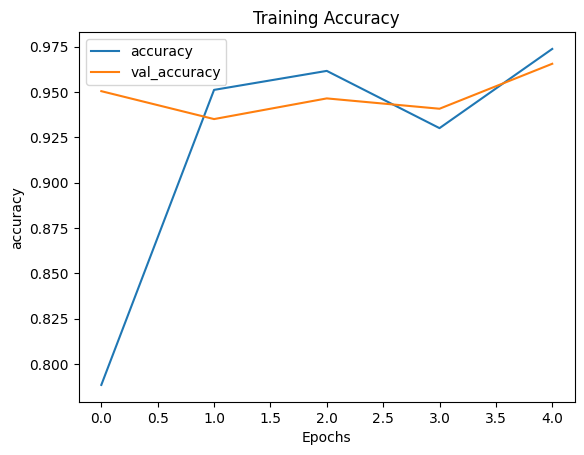

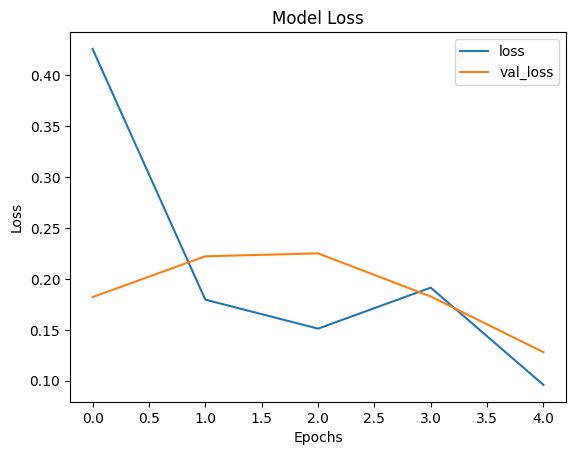

In [44]:
pd.DataFrame(historical.history)

pd.DataFrame(historical.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(historical.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

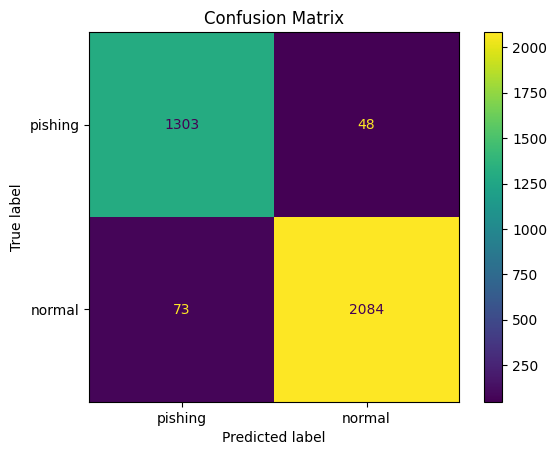

In [45]:
cnf = confusion_matrix(y_test,y_pred)
ax = ConfusionMatrixDisplay(confusion_matrix=cnf,display_labels=['pishing','normal'])
ax.plot()
plt.title("Confusion Matrix")
plt.show()

# 8| Bidirectional

In [46]:
model_bi = Sequential() # Sequential() API
model_bi.add(Embedding(input_dim=len(tk.word_index)+1,output_dim=50,input_length=150))
model_bi.add(Bidirectional(LSTM(units=100)))
model_bi.add(Dropout(0.5))
model_bi.add(Dense(1, activation='sigmoid'))

In [47]:
model_bi.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [48]:
historical  = model_bi.fit(x_train,y_train, epochs=2, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/2
877/877 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17s 17ms/step - accuracy: 0.8439 - loss: 0.3384 - val_accuracy: 0.9672 - val_loss: 0.1106
Epoch 2/2
877/877 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 15s 17ms/step - accuracy: 0.9872 - loss: 0.0439 - val_accuracy: 0.9695 - val_loss: 0.1173


In [49]:
model_bi.evaluate(x_test,y_test)

110/110 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 9ms/step - accuracy: 0.9696 - loss: 0.1155


[0.11729680001735687, 0.9694982767105103]

In [50]:
y_pred_prob_bi = model_bi.predict(x_test)
y_pred_bi = (y_pred_prob_bi > 0.5).astype(int)

110/110 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 9ms/step


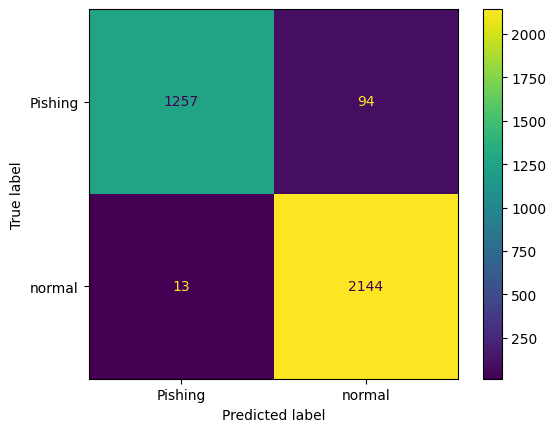

In [51]:
cnf_bi = confusion_matrix(y_test,y_pred_bi)
ax_bi = ConfusionMatrixDisplay(confusion_matrix=cnf_bi,display_labels=['Pishing','normal'])
ax_bi.plot()
plt.show()

# 9| GRU (Gated Recurrent Unit)

In [52]:
model_gru = Sequential() # Sequential() API
model_gru.add(Embedding(input_dim=len(tk.word_index)+1,output_dim=50,input_length=150))
model_gru.add(GRU(units=100))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(1, activation='sigmoid'))

In [54]:
model_gru.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [55]:
model_gru.fit(x_train,y_train, epochs=3, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/3
877/877 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 11ms/step - accuracy: 0.6650 - loss: 0.5933 - val_accuracy: 0.9441 - val_loss: 0.1658
Epoch 2/3
877/877 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 10ms/step - accuracy: 0.9619 - loss: 0.1243 - val_accuracy: 0.9712 - val_loss: 0.0922
Epoch 3/3
877/877 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 10ms/step - accuracy: 0.9936 - loss: 0.0232 - val_accuracy: 0.9778 - val_loss: 0.0703


In [56]:
y_pred_prob_gru = model_gru.predict(x_test)
y_pred_gru = (y_pred_prob_gru > 0.5).astype(int)

110/110 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 4ms/step


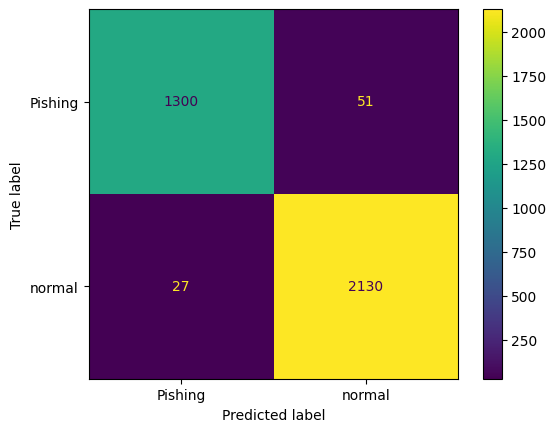

In [57]:
cnf_gru = confusion_matrix(y_test,y_pred_gru)
ax_gru = ConfusionMatrixDisplay(confusion_matrix=cnf_gru,display_labels=['Pishing','normal'])
ax_gru.plot()
plt.show()

In [76]:
from lime.lime_text import LimeTextExplainer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np


max_len = 150  

def predict_proba(texts):
    """Convert input texts to padded sequences and return class probabilities."""
    seqs = tk.texts_to_sequences(texts)
    seqs = pad_sequences(seqs, maxlen=max_len)
    preds = model_gru.predict(seqs)
    return np.hstack([1 - preds, preds])  


explainer = LimeTextExplainer(class_names=["Legit", "Phishing"])


idx = 0
sample_email = df["Email Text"][idx]  
print("üßæ Email sample:\n", sample_email, "\n")


if isinstance(sample_email, bytes):
    sample_email = sample_email.decode("utf-8")

exp = explainer.explain_instance(sample_email, predict_proba, num_features=10)


exp.show_in_notebook(text=True)





üßæ Email sample:
 re 6 1100 disc uniformitarianism re 1086 sex lang dick hudson s observations on us use of s on but not d aughter as a vocative are very thoughtprovoking but i am not sure that it is fair to attribute this to sons being treated like senior relatives for one thing we do nt normally use brother in this way any more than we do d aughter and it is hard to imagine a natural class comprising senior relatives and s on but excluding brother for another there seem to me to be differences here if i am not imagining a distinction that is not there it seems to me that the senior relative terms are used in a wider variety of contexts e g calling out from a distance to get someone s attention and hence at the beginning of an utterance whereas s on seems more natural in utterances like yes son hand me that son than in ones like son or son help me although perhaps these latter ones are not completely impossible alexis mr 

157/157 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

‚úÖ LIME explanation saved as 'lime_gru_explanation.html'
